# 3 Planet Fit with EMB

In [31]:
using PyPlot,JLD2
include("CGS.jl")

Main.CGS

In [339]:
rc("font",family="serif")
include("decompose_ttvs.jl")
include("extract_data.jl")

extract_data (generic function with 1 method)

In [312]:
function plot_ttvs(include_moon::Bool=false)
    pair_ttvs = decompose_ttvs(nplanet,ntrans,pbest_global) .* (24 * 60)
    n1,n2,n3 = ntrans
    mu1,P1,t01,ecos1,esin1 = pbest_global[1:5]
    mu2,P2,t02,ecos2,esin2 = pbest_global[6:10]
    mu3,P3,t03,ecos3,esin3 = pbest_global[11:15]
    time1 = collect(t01 .+ range(0,stop=n1-1,length=n1) .* P1)
    time2 = collect(t02 .+ range(0,stop=n2-1,length=n2) .* P2)
    tt1 = tt[1:n1]
    tt2 = tt[n1+1:n1+n2]
    ttsim1 = (ttmodel[1:n1].-t01)./365.25 #in years
    ttsim2 = (ttmodel[n1+1:n1+n2].-t02)./365.25 
    ttv1 = (tt1.-time1).* (24 * 60) #in minutes
    ttv2 = (tt2.-time2).* (24 * 60) 
    sigtt1 = sigtt[1:n1].* (24 * 60)
    sigtt2 = sigtt[n1+1:n1+n2].* (24 * 60)
    
    figsize=(10,8)
    subplot(211)
    plot(ttsim1,ttv1,linewidth=1.5,color="grey",label="Total")
    plot(ttsim1,pair_ttvs[1,2,1:n1],linewidth=1.25,label="Earth")
    plot(ttsim1,pair_ttvs[1,3,1:n1],linewidth=1.25,color="firebrick",label="Jupiter")
    errorbar(ttsim1,ttv1,sigtt1,fmt=".",color="black")
    ylabel("Venus TTVs [minutes]")
    subplot(212)
    plot(ttsim2,ttv2,linewidth=1.5,alpha=0.5,color="black",label="Total")
    plot(ttsim2,pair_ttvs[2,1,1:n2],linewidth=1.25,color="orange",label="Venus")
    plot(ttsim2,pair_ttvs[2,3,1:n2],linewidth=1.25,color="firebrick",label="Jupiter")
    if include_moon
        moon = moon_ttvs(ntrans,pbest_global) .* (24 * 60)
        plot(ttsim2,moon,linewidth=1.25,linestyle="--",color="purple")
        ylabel("Earth TTVs [minutes]")
    else
        ylabel("EMB TTVs [minutes]")
    end
    errorbar(ttsim2,ttv2,sigtt2,fmt=".",color="black")
    xlabel("Years Observed [N]")
    tight_layout()
#     legend(bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.0)
#     savefig("name.eps")
end

plot_ttvs (generic function with 4 methods)

In [315]:
function extract_planet(data,i)
eobs = zeros(0)
tobs = zeros(0)
sobs = zeros(0)
nobs = 0
for j=1:size(data,1)
  if data[j,1] == i
# Extract data:
    if data[j,4] != 0.0
      push!(eobs,data[j,2])
      push!(tobs,data[j,3])
      push!(sobs,data[j,4])
      nobs += 1
    end
  end
end
return eobs,tobs,sobs,nobs
end


extract_planet (generic function with 1 method)

In [332]:
function extractfile(filename)
    tobs = zeros(0)
    sobs = zeros(0)
    nobs = 0
    f = jldopen(String(filename), "r")  # open read-only (default)
#     for j=1:size(data,1)
#         if data[j,1] == i
#         # Extract data:
#             if data[j,4] != 0.0
#               push!(eobs,data[j,2])
#               push!(tobs,tt)
#             push!(sobs,sigtt)
#               nobs += 1
#             end
#         end
#     end
# return eobs,tobs,sobs,nobs
end

extractfile (generic function with 1 method)

In [333]:
f = extractfile("OUTPUTS/p3_fittry001params.jld2")

JLDFile /Users/chell/research/ttv_ss/OUTPUTS/p3_fittry001params.jld2 (read-only)
 ├─🔢 param_p3
 ├─🔢 lprob_p3
 ├─🔢 lprob_best
 ├─🔢 pbest_global
 ├─🔢 ntrans
 ├─🔢 nplanet
 ├─🔢 tt0
 ├─🔢 tt
 ├─🔢 ttmodel
 ├─🔢 sigtt
 ├─🔢 p3in
 ├─🔢 p3out
 ├─🔢 np3
 └─🔢 nphase

In [340]:
extract_data("mcmc_try001results.jld2")

JLDFile /Users/chell/research/ttv_ss/mcmc_try001results.jld2 (read-only)
 ├─🔢 par_mcmc
 ├─🔢 lprob_mcmc
 ├─🔢 nwalkers
 ├─🔢 nsteps
 ├─🔢 accept
 └─🔢 iburn

### Plot of simulated years observed vs TTVs

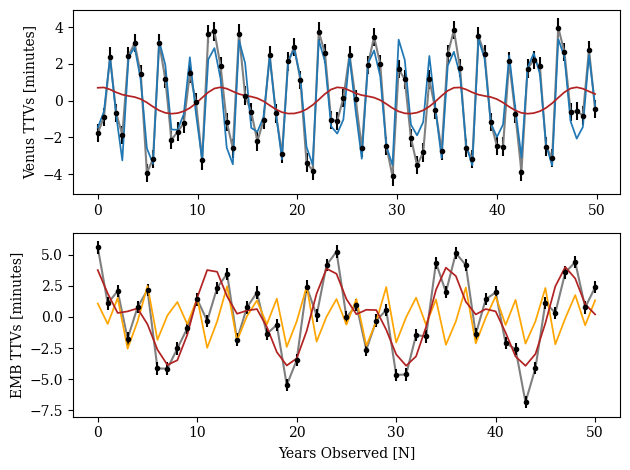

Remember to load appropriate files!!!


In [313]:
@load ("OUTPUTS/p3_fittry001params.jld2")
@load ("mcmc_try001results.jld2")
plot_ttvs(false)

In [ ]:
pname = ["mu_1","P_1","t01","e1 cos(om1)","e1 sin(om1)",
            "mu_2","P_2","t02","e2 cos(om2)","e2 sin(om2)",
            "mu_3","P_3","t03","e3 cos(om3)","e3 sin(om3)",
            "tmax sin(phi0)","tmax cos(phi0)","deltaphi"]

In [233]:
function vectorize_data(include_moon::Bool=false)
    names = ["mu", "P", "t0", "e cos(om)", "e sin(om)"]
    planet = ["venus", "earth", "jupiter"]
    nparam = length(param)*nplanet+1
    state_total = zeros((nsteps-iburn)*nwalkers+50,nparam-1)
    for iparam=1:nparam-1
    state_total[:,iparam] += vec(par_mcmc[:,iburn:nsteps,iparam])
    if iparam < nparam
            pname = string(planet[div(iparam-1,5)+1]," ",names[mod(iparam-1,5)+1])
    end
    #     println("index: ",iparam, " ",pname," : ",pbest_global[iparam])
    end
end
# mu1,P1,t01,ecos1,esin1 = pbest_global[1:5]
# mu2,P2,t02,ecos2,esin2 = pbest_global[6:10]
# mu3,P3,t03,ecos3,esin3 = pbest_global[11:15]
# scatter(vec(par_mcmc[1:nwalkers,1:nsteps,1]),vec(par_mcmc[1:nwalkers,1:nsteps,5]))

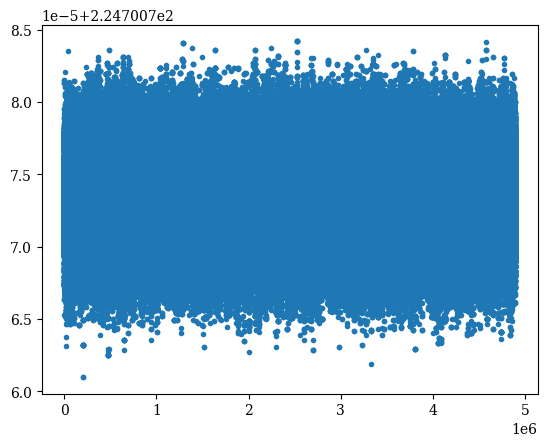

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x153cab760>

In [244]:
plot(state_total[:,2],".")

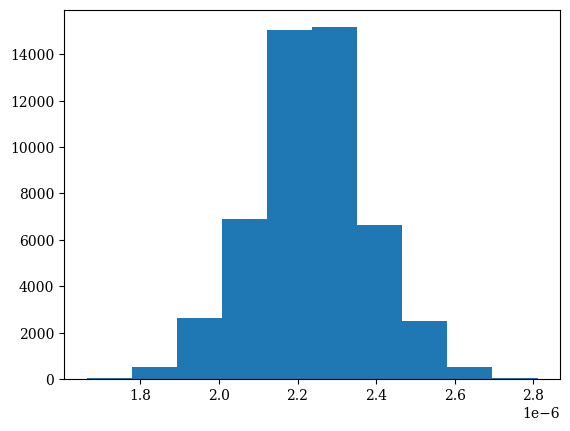

([46.0, 515.0, 2644.0, 6917.0, 15026.0, 15162.0, 6634.0, 2486.0, 516.0, 54.0], [1.6634493751895332e-6, 1.7781865359591875e-6, 1.8929236967288415e-6, 2.007660857498496e-6, 2.12239801826815e-6, 2.237135179037804e-6, 2.351872339807458e-6, 2.4666095005771123e-6, 2.5813466613467663e-6, 2.6960838221164207e-6, 2.8108209828860747e-6], (PyObject <matplotlib.patches.Rectangle object at 0x16038a8e0>, PyObject <matplotlib.patches.Rectangle object at 0x16038a760>, PyObject <matplotlib.patches.Rectangle object at 0x16038adc0>, PyObject <matplotlib.patches.Rectangle object at 0x1603970d0>, PyObject <matplotlib.patches.Rectangle object at 0x1603973a0>, PyObject <matplotlib.patches.Rectangle object at 0x160397670>, PyObject <matplotlib.patches.Rectangle object at 0x160397940>, PyObject <matplotlib.patches.Rectangle object at 0x160397c10>, PyObject <matplotlib.patches.Rectangle object at 0x160397ee0>, PyObject <matplotlib.patches.Rectangle object at 0x1606ac1f0>))

In [216]:
hist(state_total[:,1],b)

In [ ]:
2.433503765402889e6

### MCMC steps and parameters

In [ ]:
function plot_mcmc(include_moon::Bool=false)
    figsize=(9,5)
    for i=1:5
    subplot(5,1,i)
    for j=1:nwalkers 
    plot(par_mcmc[j,1:nsteps,i])
    ylabel(pname[i])
    end
    tight_layout()
    end
    name = string("IMAGES/MCMCstepsp1.png")
    clf()
    figsize=(9,5)
    for i=1:5
    subplot(5,1,i)
    for j=1:nwalkers 
    plot(par_mcmc[j,1:nsteps,i+5])
    ylabel(pname[i+5])
    end
    tight_layout()
    end
    name = string("IMAGES/MCMCstepsp2.png")
    clf()
    figsize=(9,5)
    for i=1:5
    subplot(5,1,i)
    for j=1:nwalkers 
    plot(par_mcmc[j,1:nsteps,i+10])
    ylabel(pname[i+10])
    end
    tight_layout()
    end
    name = string("IMAGES/MCMCstepsp3.png")
    clf()
    if include_moon
        figsize=(5,3)
        for i=1:3
        subplot(3,1,i)
        for j=1:nwalkers 
        plot(par_mcmc[j,1:nsteps,i+15])
        ylabel(pname[i+15])
        end
        # tight_layout()
        end
        name = string("IMAGES/MCMCstepsmoon.png")
    end
savefig(name)
end
# Make plot of MCMC parameters after burn-in
# figsize=(8,6)
# for i=2:nparam
#   for j=1:i-1
#     scatter(vec(par_mcmc[1:nwalkers,iburn:nsteps,i]),vec(par_mcmc[1:nwalkers,iburn:nsteps,j]))
#     xlabel(pname[i])
#     ylabel(pname[j])
#   end
# end
# name = string("IMAGES/MCMCparams",label,".png")

## 3 Planet then Moon Fit without EMB

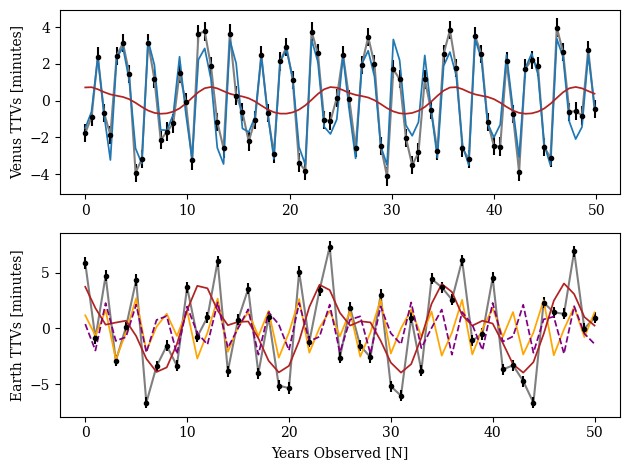

Remember to load appropriate files!!!


In [314]:
@load ("OUTPUTS/moon_fittestparams.jld2")
@load ("mcmc_mtestresults.jld2") 
plot_ttvs(true)